In [1]:
## importing the necessary packages
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [2]:
## since in the data some observation has unwanted values, we are replacing them with missing values 
data = pd.read_csv('cars.csv',na_values = '?')
data.head(4)

,car name,cyl,disp,hp,wt,acc,yr,mpg
0,chevrolet chevelle malibu,8,307.0,130.0,3504,12.0,70,18.0
1,buick skylark 320,8,350.0,165.0,3693,11.5,70,15.0
2,plymouth satellite,8,318.0,150.0,3436,11.0,70,18.0
3,amc rebel sst,8,304.0,150.0,3433,12.0,70,16.0


In [3]:
## information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          392 non-null float64
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


# Treating missing values

In [4]:
## the column 'hp' has 6 missing values
data.isnull().sum()

car name    0
cyl         0
disp        0
hp          6
wt          0
acc         0
yr          0
mpg         0
dtype: int64

In [5]:
## but before handling the missing values(replacing with mean), we sholud know that there are some clusters present
## so lets find out the clusters wrt 'hp' and then replace missing values with their corresponding avg

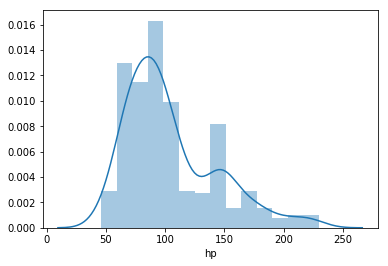

In [6]:
hp = data['hp'].dropna()               ## the plot is made without missing values
sn.distplot(hp,kde = True)
## there are 3 clusters(with 3rd one very small)

In [7]:
##since we dont know which cluster they belong,lets take weighted avg of these 3 and use them for missing values
## 1st cluster => range(0,120) 2nd => (120,210) 3rd => (210,250)
hp.describe()
## 1st cluster has almost 75% of data,hence remaining is 25% of data
##since 3rd cluster is very small lets say it has 3%(approx) of data and remaining is 22% which is of the 2nd cluster 

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: hp, dtype: float64

In [8]:
## from the figure we can interpret the mean for all 3 clusters by seeing the ('hp')values for corresponding gaussian curves 
w_avg = ((0.75*90)+(0.22*150)+(0.03*220))
data['hp'].fillna(value = w_avg,inplace = True)

# Analysing the characteristics of the data, by both numerically and visually

In [9]:
data.describe()
## the columns except 'acc' and 'yr' are having deviation b/w their mean and median 
## from this we can infer that these columns have either outiers or clusters or both, we can be sure when we see it visually

,cyl,disp,hp,wt,acc,yr,mpg
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,5.454774,193.425879,104.509045,2970.424623,15.568090,76.010050,23.514573
std,1.701004,104.269838,38.200536,846.841774,2.757689,3.697627,7.815984
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,9.000000
25%,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,17.500000
50%,4.000000,148.500000,95.000000,2803.500000,15.500000,76.000000,23.000000
75%,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,29.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,46.600000


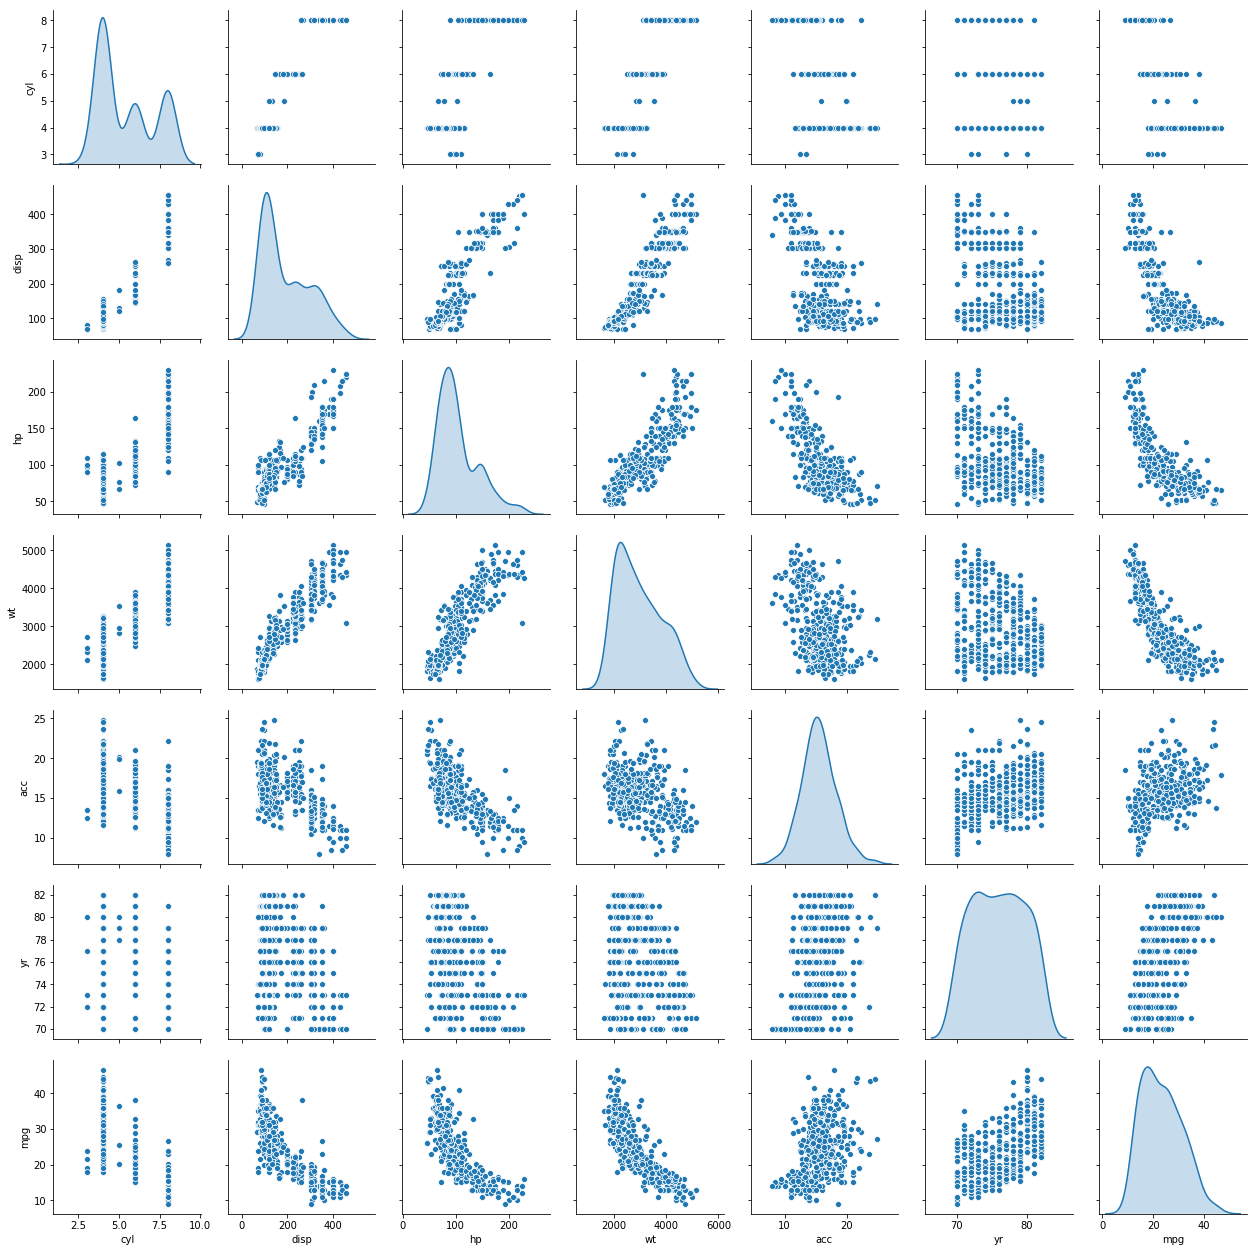

In [10]:
sn.pairplot(data,diag_kind = 'kde')
## from the gaussian curve we can interpret that the data has 2 or 3 clusters hidden in it

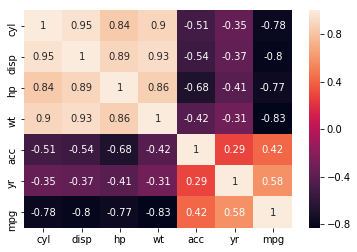

In [11]:
sn.heatmap(data.corr(),annot = True)
## we can see most of the features are dependent among each other with corr score above 0.85

$ We can infer that there are 2 or 3 clusters in our data and also there is presence of outliers.

$ The col 'acc' is almost independent with all others and some of the col like 'dip','hp','wt' shows dependency among them.

$ The col 'cyl' and 'yr' are multivalued(categorical) numerical.

$ As 'mpg' is target col(which is continous) for better regression results the features has to be independent and all dependent with the target,but the feature space here is with dependent col(corr score > 0.85) this may lead to extra noise in the result. Its better to add some col independent with features and dependent with target.(since more features leads to high variance make sure you dont add many). 

$ Since I cant form an independent col from the existing features ,I'm continuing as it is but the result wont be good. 

In [12]:
##since we know that there are some clusters lets find and arrange datapoints respectively 
##and analyse charaacteristics of each group formed
data.drop(labels = 'car name',inplace = True,axis = 1)  #dropping the name col


In [13]:
data.drop(labels = 'yr',inplace = True,axis = 1)   ##since 'yr' col is less dependent with target corr score 0.58 lets drop it

In [14]:
data_z = data.apply(zscore)  ##normalizing the data


def optimal_clusters(df):
    
    ##using kmeans to find optimal cluster
    cl_range = (2,3,4,5,6)   ## since we know its around 2,3
    cl_err = []
    centroids = []
    for val in cl_range:
        cl = KMeans(n_clusters = val,n_init = 5)
        cl.fit(df)
        centroids.append(cl.cluster_centers_)
        cl_err.append(cl.inertia_)
    cl_data = pd.DataFrame({'num_clusters':cl_range,'centroids':centroids,'cluster_errors':cl_err})
    print(cl_data)
    
    # Making a plot(elbow plot) inorder to know the optimal no. of clusters
    plt.figure(figsize=(12,6))
    plt.plot( cl_data.num_clusters, cl_data.cluster_errors, marker = "o" )
    
    
def cluster_check(df,cl):

    clust = KMeans(n_clusters = cl)
    clust.fit(df)
    
    result = clust.predict(df)
    ##plotting data points with respective clusters to check any color switch(cluster switch) happens
    fig = plt.figure(figsize = (20,20))
    axes = fig.subplots(2,1)
    ##since 'wt' col is the most dependent(corr score -0.83) on target col among feature space,hence we are using 'wt' col with 
    ##target to check
    axes[0].scatter(df['wt'],df['mpg'])
    axes[0].set_title('before clustering')
    axes[1].scatter(df['wt'],df['mpg'],c = result,cmap = 'viridis')
    axes[1].set_title('after clustering')
    return result

   num_clusters                                          centroids  \
0             2  [[1.4755517212173601, 1.4448832142424095, 1.41...   
1             3  [[-0.8534769576593548, -0.8032137441166594, -0...   
2             4  [[-0.8474690227500431, -0.7521154753985032, -0...   
3             5  [[-0.7740392436213954, -0.6540184729406266, -0...   
4             6  [[-0.7757714820920907, -0.6846592103906317, -0...   

   cluster_errors  
0      946.111311  
1      611.352044  
2      494.856616  
3      425.705384  
4      373.090574  


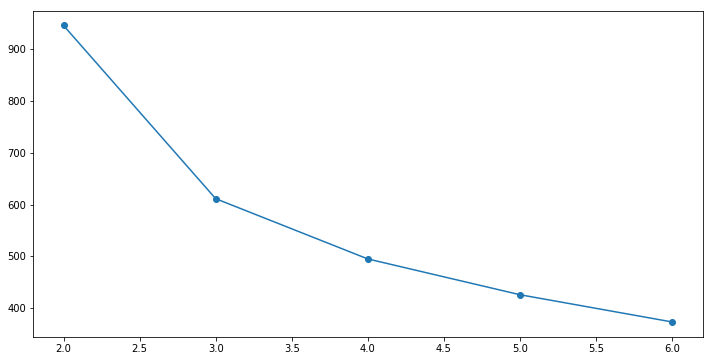

In [15]:
## since normalising the data has impact in Kmeans, lets try it with and without scaling
optimal_clusters(data_z)  #scaled data

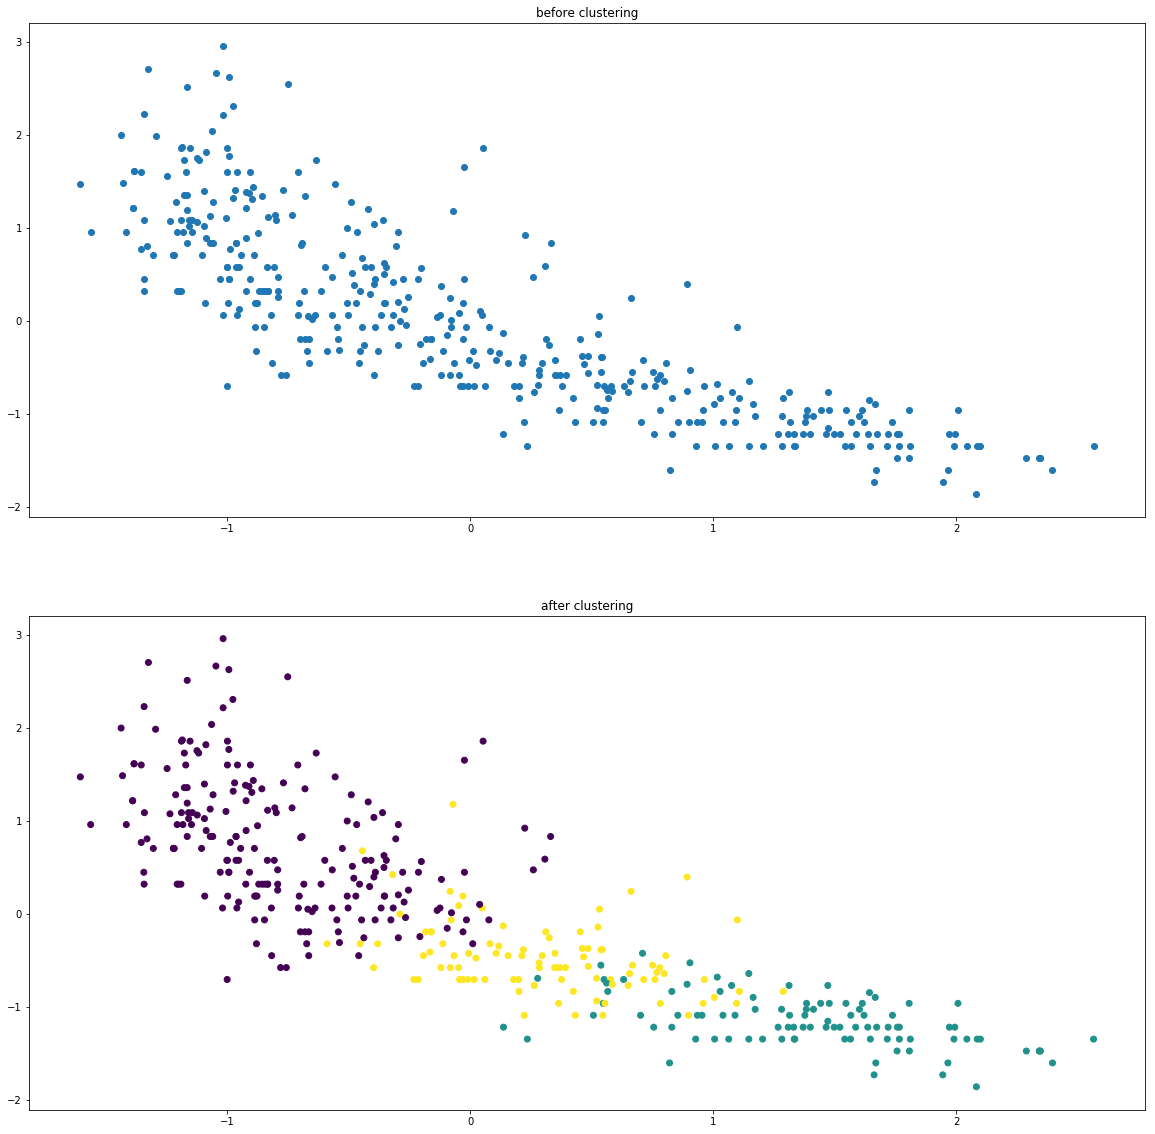

In [16]:
##from the scaled data we get 3 as otpimal clusters,lets check 
predict_scaled = cluster_check(data_z,3)
## from the 2nd fig we can infer that there are lot of data points switched in between the clusters 
##and this is not efficient one

   num_clusters                                          centroids  \
0             2  [[4.3183673469387776, 124.3612244897956, 83.46...   
1             3  [[5.7777777777777795, 210.67460317460325, 105....   
2             4  [[3.9785714285714313, 98.11071428571405, 73.80...   
3             5  [[4.649484536082475, 152.4432989690722, 94.889...   
4             6  [[3.9907407407407414, 94.11574074074063, 70.21...   

   cluster_errors  
0    7.429683e+07  
1    3.420450e+07  
2    1.905454e+07  
3    1.376749e+07  
4    1.033195e+07  


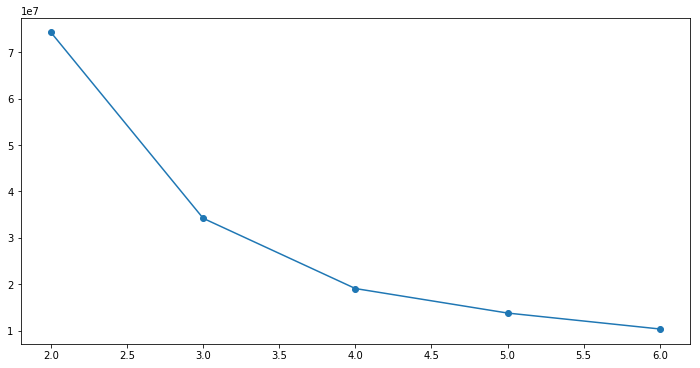

In [17]:
optimal_clusters(data)  # without scaling

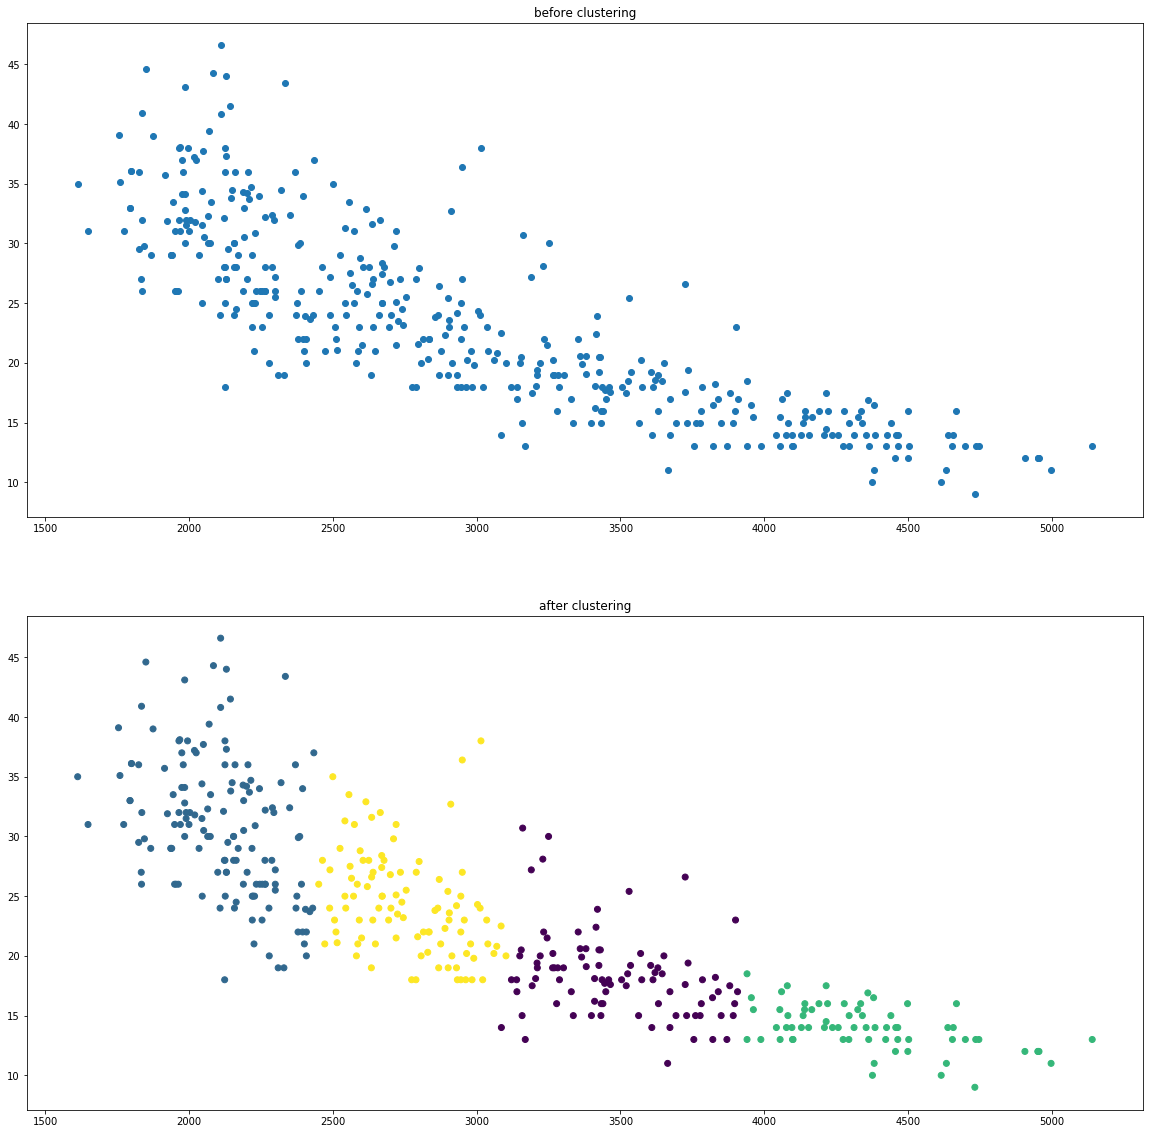

In [18]:
## we got 4 as optimal clusters
predicted = cluster_check(data,4)
#from the 2nd fig we can see that data points are correctly segregated and it is better to proceed without scaling for this data

In [19]:
##so now lets segregate the datapoints respective to their group with new col 'grp'
data['grp'] = predicted
data.head(10)

,cyl,disp,hp,wt,acc,mpg,grp
0,8,307.0,130.0,3504,12.0,18.0,0
1,8,350.0,165.0,3693,11.5,15.0,0
2,8,318.0,150.0,3436,11.0,18.0,0
3,8,304.0,150.0,3433,12.0,16.0,0
4,8,302.0,140.0,3449,10.5,17.0,0
5,8,429.0,198.0,4341,10.0,15.0,2
6,8,454.0,220.0,4354,9.0,14.0,2
7,8,440.0,215.0,4312,8.5,14.0,2
8,8,455.0,225.0,4425,10.0,14.0,2
9,8,390.0,190.0,3850,8.5,15.0,0


C:\Users\Asus\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Asus\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\Asus\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


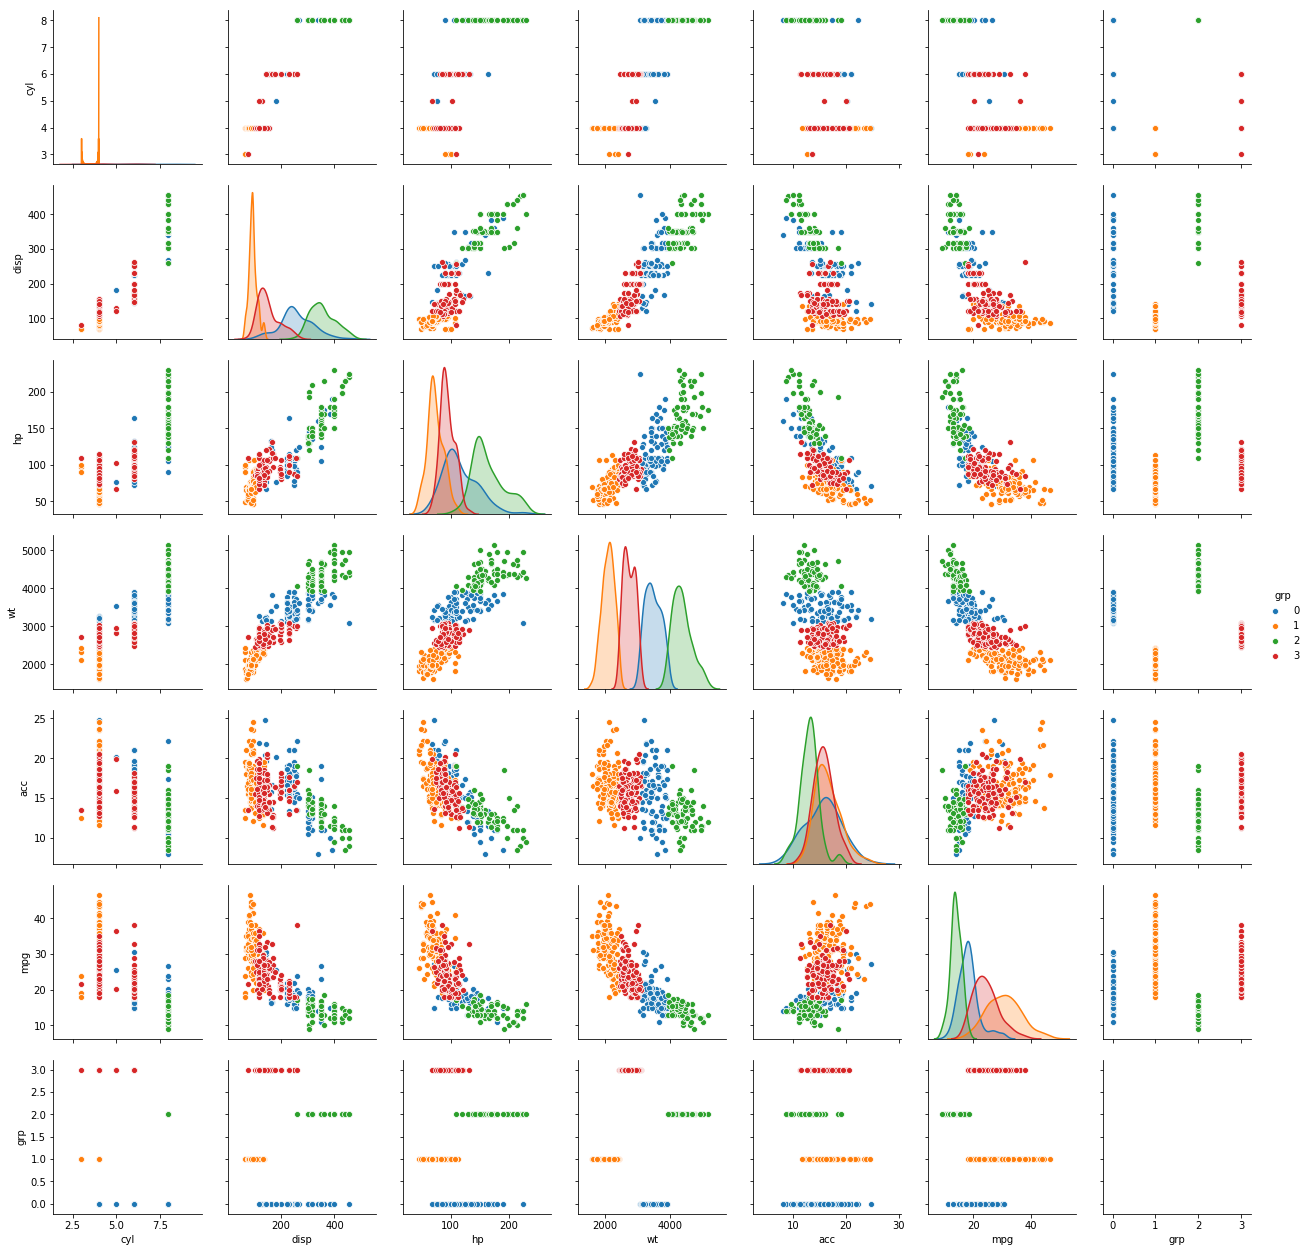

In [20]:
sn.pairplot(data,diag_kind = 'kde',hue = 'grp') 

In [21]:
## from the above plot we can see that there are no more clusters present since there is no extra gaussian curves for each col.
## but we can see the presence of outliers, lets make seperate datasets based on the groups and treat them.
cluster_1 = data.where(data['grp'] == 0)
cluster_1.dropna()
cluster_2 = data.where(data['grp'] == 1)
cluster_2.dropna()
cluster_3 = data.where(data['grp'] == 2)
cluster_3.dropna()
cluster_4 = data.where(data['grp'] == 3)
cluster_4.dropna()
    

,cyl,disp,hp,wt,acc,mpg,grp
15,6.0,198.0,95.0,2833.0,15.5,22.0,3.0
16,6.0,199.0,97.0,2774.0,15.5,18.0,3.0
17,6.0,200.0,85.0,2587.0,16.0,21.0,3.0
20,4.0,110.0,87.0,2672.0,17.5,25.0,3.0
24,6.0,199.0,90.0,2648.0,15.0,21.0,3.0
33,6.0,232.0,100.0,2634.0,13.0,19.0,3.0
45,6.0,258.0,110.0,2962.0,13.5,18.0,3.0
76,4.0,121.0,112.0,2933.0,14.5,18.0,3.0
77,4.0,121.0,76.0,2511.0,18.0,22.0,3.0
78,4.0,120.0,87.0,2979.0,19.5,21.0,3.0


# Treating outlier for cluster1

In [22]:
cluster_1.describe()
## we can see all the col are not having much skews to be worried about,since their maen and medium are almost equal

,cyl,disp,hp,wt,acc,mpg,grp
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.0
mean,6.640449,259.966292,116.808989,3484.483146,15.675281,18.352809,0.0
std,1.170151,62.132638,29.761123,234.070313,3.397669,3.598582,0.0
min,4.000000,120.000000,67.000000,3086.000000,8.000000,11.000000,0.0
25%,6.000000,225.000000,100.000000,3278.000000,13.200000,16.000000,0.0
50%,6.000000,250.000000,110.000000,3439.000000,15.800000,18.000000,0.0
75%,8.000000,304.000000,139.000000,3672.000000,18.000000,19.900000,0.0
max,8.000000,455.000000,225.000000,3907.000000,24.800000,30.700000,0.0


# For cluster2

In [23]:
cluster_2.describe()
##same for cluster2 it doesnt have much skews hence no outliers

,cyl,disp,hp,wt,acc,mpg,grp
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.0
mean,3.978723,98.258865,73.931206,2111.439716,16.591489,30.791489,1.0
std,0.144819,15.219771,13.779686,184.019074,2.435467,5.868530,0.0
min,3.000000,68.000000,46.000000,1613.000000,11.600000,18.000000,1.0
25%,4.000000,90.000000,65.000000,1980.000000,14.700000,26.000000,1.0
50%,4.000000,97.000000,71.000000,2126.000000,16.400000,30.900000,1.0
75%,4.000000,105.000000,84.000000,2246.000000,18.000000,34.500000,1.0
max,4.000000,140.000000,113.000000,2434.000000,24.600000,46.600000,1.0


# For cluster3

In [24]:
cluster_3.describe()
## here the 'hp' col has some skew which has to be treated

,cyl,disp,hp,wt,acc,mpg,grp
count,69.0,69.000000,69.000000,69.000000,69.000000,69.000000,69.0
mean,8.0,356.536232,165.130435,4366.594203,13.042029,13.991304,2.0
std,0.0,45.243322,27.528548,286.654553,1.827358,1.890980,0.0
min,8.0,260.000000,110.000000,3940.000000,8.500000,9.000000,2.0
25%,8.0,318.000000,148.000000,4140.000000,12.000000,13.000000,2.0
50%,8.0,350.000000,153.000000,4335.000000,13.000000,14.000000,2.0
75%,8.0,400.000000,180.000000,4499.000000,14.000000,15.500000,2.0
max,8.0,455.000000,230.000000,5140.000000,19.000000,18.500000,2.0


In [25]:
##lets apply log inorder to treat them
cluster_3['hp'] = np.log(cluster_3['hp'])
cluster_3.dropna()
cluster_3.describe()
## now we can see that mean and medium of 'hp' is almost same with the outlier being treated

,cyl,disp,hp,wt,acc,mpg,grp
count,69.0,69.000000,69.000000,69.000000,69.000000,69.000000,69.0
mean,8.0,356.536232,5.093665,4366.594203,13.042029,13.991304,2.0
std,0.0,45.243322,0.161284,286.654553,1.827358,1.890980,0.0
min,8.0,260.000000,4.700480,3940.000000,8.500000,9.000000,2.0
25%,8.0,318.000000,4.997212,4140.000000,12.000000,13.000000,2.0
50%,8.0,350.000000,5.030438,4335.000000,13.000000,14.000000,2.0
75%,8.0,400.000000,5.192957,4499.000000,14.000000,15.500000,2.0
max,8.0,455.000000,5.438079,5140.000000,19.000000,18.500000,2.0


# For cluster4

In [26]:
##for cluster4
cluster_4.describe()
## here the col 'disp' has some skew,so lets treat it

,cyl,disp,hp,wt,acc,mpg,grp
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.0
mean,4.717172,155.464646,94.750505,2758.606061,15.774747,24.428283,3.0
std,0.969330,39.827258,12.361918,176.586905,1.896686,4.368371,0.0
min,3.000000,80.000000,67.000000,2451.000000,11.300000,18.000000,3.0
25%,4.000000,121.000000,86.500000,2610.000000,14.500000,21.000000,3.0
50%,4.000000,144.000000,92.000000,2735.000000,15.700000,24.000000,3.0
75%,6.000000,173.000000,104.000000,2912.000000,17.000000,27.000000,3.0
max,6.000000,262.000000,132.000000,3102.000000,20.500000,38.000000,3.0


In [27]:
cluster_4['disp'] = np.log(cluster_4['disp'])
cluster_4.dropna()
cluster_4.describe()

,cyl,disp,hp,wt,acc,mpg,grp
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.0
mean,4.717172,5.016534,94.750505,2758.606061,15.774747,24.428283,3.0
std,0.969330,0.241511,12.361918,176.586905,1.896686,4.368371,0.0
min,3.000000,4.382027,67.000000,2451.000000,11.300000,18.000000,3.0
25%,4.000000,4.795791,86.500000,2610.000000,14.500000,21.000000,3.0
50%,4.000000,4.969813,92.000000,2735.000000,15.700000,24.000000,3.0
75%,6.000000,5.153292,104.000000,2912.000000,17.000000,27.000000,3.0
max,6.000000,5.568345,132.000000,3102.000000,20.500000,38.000000,3.0


## Applying Linear Regression to predict mpg

In [30]:
def Lreg(X,Y):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=1)
    model = LinearRegression()
    model.fit(x_train,y_train)
    print('model score is ',model.score(x_test,y_test))
    print('model coefficients are \n',model.coef_)
    
    

In [38]:
## for cluster1
cluster_1.drop(labels = 'grp',inplace = True,axis = 1)
x1 = cluster_1.drop(labels = 'mpg',axis = 1)
x1.dropna(inplace = True)
y1 = cluster_1['mpg']
y1.dropna(inplace = True)
Lreg(x1,y1)
## wecan see that the score is -ve(i.e the r^2),when r^2 value is -ve it means sum of sqrd residuals is greater than sum of 
##sqrd of the total, this means the model is worse.

model score is  -0.158428727761166
model coefficients are 
 [ 1.35634653 -0.01443965 -0.02110274 -0.00365627  0.60208282]


In [39]:
#for cluster 2
cluster_2.drop(labels = 'grp',inplace = True,axis = 1)
x2 = cluster_2.drop(labels = 'mpg',axis = 1)
x2.dropna(inplace = True)
y2 = cluster_2['mpg']
y2.dropna(inplace = True)
Lreg(x2,y2)
## same for cluster 2 since the value is -ve the model is worse

model score is  -0.027081805884562327
model coefficients are 
 [ 1.40072799e+01 -1.18386319e-01 -1.10912467e-01 -3.40053791e-03
 -1.23711167e-01]


In [40]:
#for cluster3
cluster_3.drop(labels = 'grp',inplace = True,axis = 1)
x3 = cluster_3.drop(labels = 'mpg',axis = 1)
x3.dropna(inplace = True)
y3 = cluster_3['mpg']
y3.dropna(inplace = True)
Lreg(x3,y3)
## hear the R^2 value is +ve and its very low, this model explains only 5% of variance in the data.

model score is  0.05731237710688119
model coefficients are 
 [ 0.00000000e+00  1.35060896e-02 -7.25095135e+00 -3.49374514e-03
 -2.86799345e-01]


In [41]:
#for cluster4
cluster_4.drop(labels = 'grp',inplace = True,axis = 1)
x4 = cluster_4.drop(labels = 'mpg',axis = 1)
x4.dropna(inplace = True)
y4 = cluster_4['mpg']
y4.dropna(inplace = True)
Lreg(x4,y4)
## here the R^2 value is -ve, hence we can conclude that model is worse 

model score is  -0.1243674398985215
model coefficients are 
 [-4.17489883e-01 -5.66991492e+00 -1.09538212e-01 -1.46610934e-03
 -3.81792736e-01]


The linear regression model doesnt fit to find 'mpg' base on the clusters, since each cluster has datapoints which are almost
independent with target such that fitting a straight line is not efficient.

We could try without splitting the clusters ,since we got each features showing some dependency(with corr score > 0.77) with the target('mpg').